# test the relation between knowledge distribition and the NLL of ripple effect
* defination of knowledge distribution: 
    * A->B edit A:->+C -> change B -> ripple effect
    * distribution between A and C: if a and c are not so related, the ripple cannot map the change in A to problem C so can not do ripple 
    * ways to measure distribition: $cos_{llama32layers}(gradient(A), gradient(C))$ on original model
    * ways to detect ripple effect: the NLL of B on edited model

In [2]:
from utils.all_imports import *
# from utils.calculating_gradient import *
from utils.calculating_probability import *
torch.cuda.set_device(0)
from utils.all_imports import *
from utils.data_processing_utils import *


# import model and test_data
model,tokenizer,batch_first= load_model_and_tokenizer("/data/chihan3/cache/llama-2/llama-2-7b-hf",None,0)
hparams = ROMEHyperParams.from_name("llama-7b")
template = Template(name="default")
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

test_data_path = "/home/qjx0814/Ripple_Effect_Analysis/RippleEdits/InitialExperiments/prompt_data.json"
with open(test_data_path,"r") as json_file:
    test_data = json.load(json_file)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
inner_product = inner_product_between_contexts(model,tokenizer,query['condition_query']['prompt'],edited_sentence,query['condition_query']['answer'],edited_sentence_answer,model_device=1,plot=True)

In [15]:
with open(f"inner_product_results{len(inner_product_results)}.json","w") as json_file:
    json.dump(inner_product_results,json_file)

In [51]:
inner_product_results = []
for one_data in tqdm(test_data[16:]):
    edited_data = make_edited_data(one_data)
    edited_sentence_answer = edited_data['target']
    edited_sentence = edited_data['prompt'].replace(" {} ",f" {edited_data['subject']} ")
    with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
        model_edited, diff_weights = apply_rome_to_model(model,tokenizer,[edited_data],hparams,batch_first,copy=True,return_diff_weights=True)
    
    # calculate the inner product between the gradient of the original sentence and the gradient of conditional sentence
    for query in one_data['compositional_I_problems']:
        one_data_results = dict() # initialize
        with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
            inner_product = inner_product_between_contexts(model,tokenizer,query['condition_query']['prompt'],edited_sentence,query['condition_query']['answer'],edited_sentence_answer,model_device=6,plot=True)
            one_data_results['inner_product'] = inner_product
        print(query['condition_query']['prompt'],edited_sentence,query['condition_query']['answer'],edited_sentence_answer)
        with io.StringIO() as buf, redirect_stdout(buf), redirect_stderr(buf):
            one_data_results['edited_sentence'] = edited_sentence
            one_data_results['edited_sentence_answer'] = edited_sentence_answer
            one_data_results['ripple_sentence'] = query['compositional_query']['prompt']
            one_data_results['ripple_sentence_answer'] = query['compositional_query']['answer']
            one_data_results['condition_query'] = query['condition_query']['prompt']
            one_data_results['condition_query_answer'] = query['condition_query']['answer']
            
            result = calculate_min_probability(model_edited,tokenizer,one_data_results['ripple_sentence'],[one_data_results['ripple_sentence_answer']],space_n=10)
        one_data_results['NLL'] = result
        inner_product_results.append(one_data_results)

  0%|          | 0/257 [00:00<?, ?it/s]

The name of the currency in Italian Republic is The name of the country of citizenship of John Prine is Milanese scudo Italian Republic
The name of the continent which Italian Republic is part of is The name of the country of citizenship of John Prine is Europe Italian Republic
The name of the capital city of Italian Republic is The name of the country of citizenship of John Prine is Milan Italian Republic


  0%|          | 0/257 [01:10<?, ?it/s]


ValueError: Expected input batch_size (4) to match target batch_size (1).

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [52]:
print(query['condition_query']['prompt'],edited_sentence,query['condition_query']['answer'],edited_sentence_answer)

The official language of Italian Republic is The name of the country of citizenship of John Prine is Italian Italian Republic


In [2]:
# debug
from torch import nn
a = "The official language of Italian Republic is"
b = "The name of the country of citizenship of John Prine is"
c = "Italian"
d = "Italian Republic"
inner_product = inner_product_between_contexts(model,tokenizer,a,b,c,d,model_device=0,plot=False)

ValueError: Expected input batch_size (4) to match target batch_size (1).

In [4]:
a+" "+c

'The official language of Italian Republic is Italian'

In [5]:
c

'Italian'

In [3]:
gradient1,loss1 = calculate_gradient(model,tokenizer,a+" "+c,c,plot=False)

ValueError: Expected input batch_size (4) to match target batch_size (1).

In [37]:
min(one_example['NLL'])

5.412130355834961

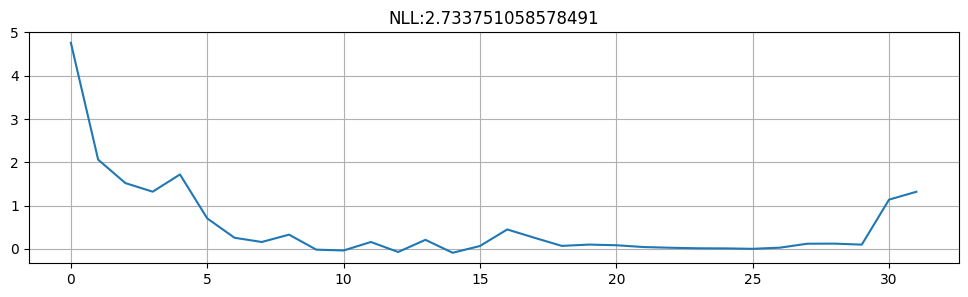

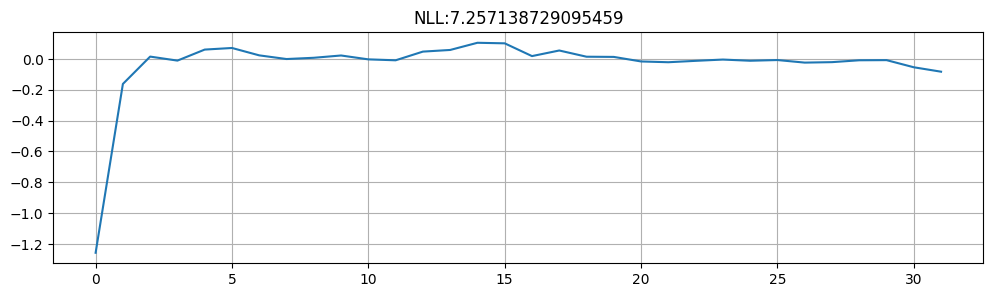

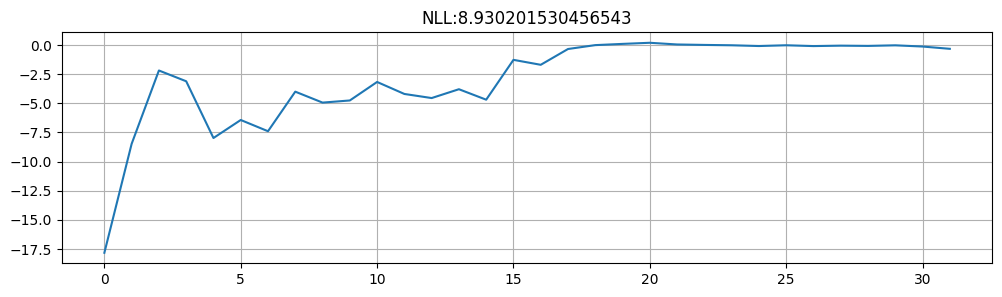

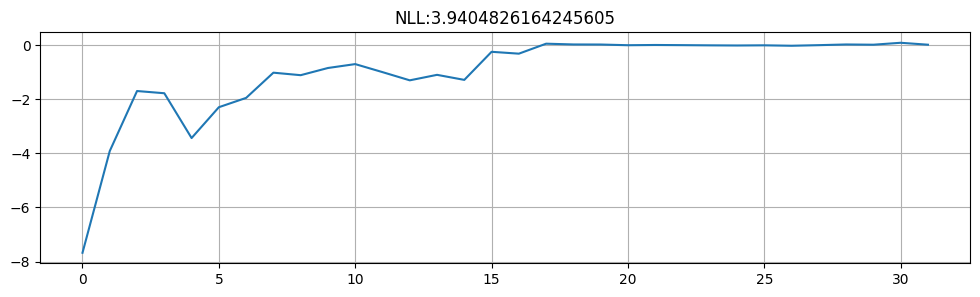

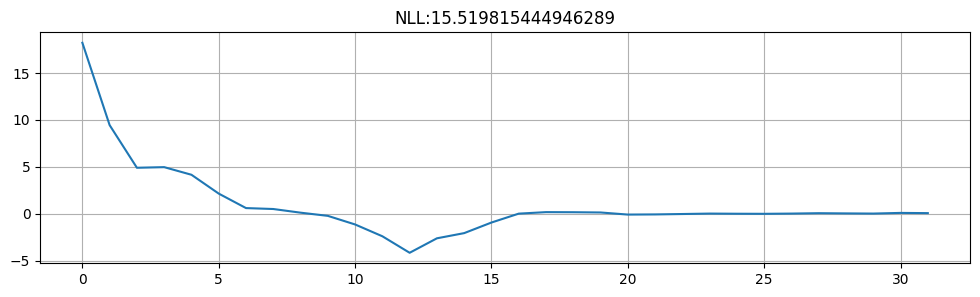

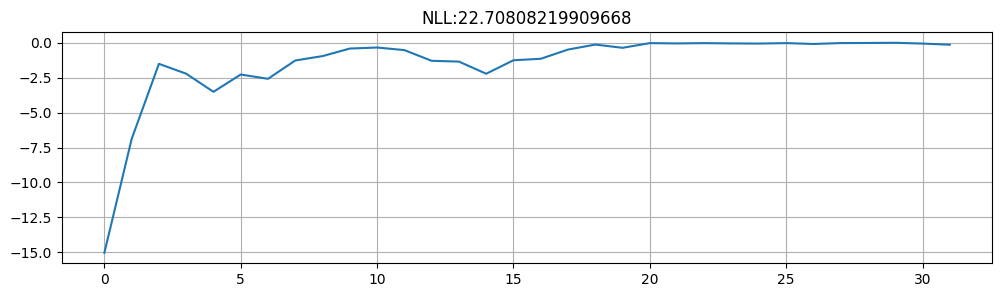

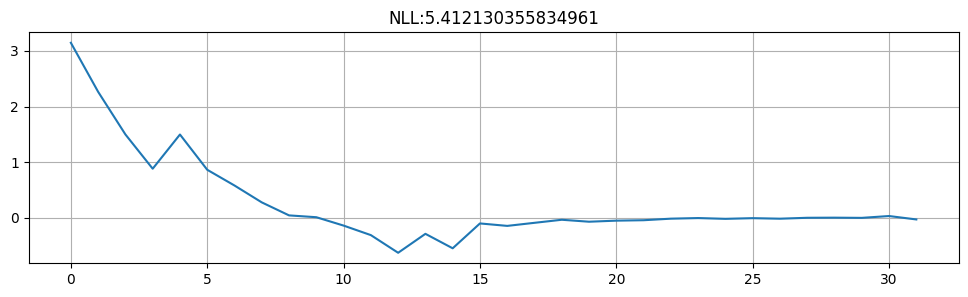

In [39]:
for one_example in inner_product_results:
    mlp_down_project = [one_example['inner_product'][i] for i in one_example['inner_product'] if 'o_proj' in i]
    plt.figure(figsize=(12,3))
    plt.plot(mlp_down_project)
    plt.grid(True)
    plt.title(f"NLL:{min(one_example['NLL'])}")
    plt.show()

{'edit': {'prompt': 'The name of the country of citizenship of John Prine is Italian Republic.',
  'subject_id': 'John Prine',
  'relation': 'COUNTRY_OF_CITIZENSHIP',
  'target_id': 'Italian Republic',
  'original_fact': {'prompt': 'The name of the country of citizenship of John Prine is United States of America.',
   'subject_id': 'John Prine',
   'relation': 'COUNTRY_OF_CITIZENSHIP',
   'target_id': 'United States of America'}},
 'compositional_I_problems': [{'compositional_query': {'prompt': 'The name of the currency in the country of citizenship of John Prine is',
    'answer': 'Milanese scudo',
    'subject': 'John Prine',
    'target': 'Italian Republic',
    'relation': 'COUNTRY_OF_CITIZENSHIP'},
   'condition_query': {'prompt': 'The name of the currency in Italian Republic is',
    'answer': 'Milanese scudo',
    'subject': 'Italian Republic',
    'target': 'Milanese scudo',
    'relation': 'CURRENCY'}},
  {'compositional_query': {'prompt': 'The name of the continent which the 